# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

ERROR: Invalid requirement: './python'
It looks like a path. File './python' does not exist.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='Reacher_20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
all_scores = []
for _ in range(100):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    steps = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        steps += 1
        if np.any(dones):                                  # exit loop if episode finished
            break
    all_scores.append(scores)
    print('Total score (averaged over agents) this episode: {} took steps {}'.format(np.mean(scores),steps))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('Score')
plt.ylabel('Frequency')
mean = np.mean([np.mean(score) for score in all_scores])
std = np.std([np.mean(score) for score in all_scores])
plt.title('Distribution of Scores for Agent with Random Uniform Sampled Actions\n Mean {:2f} and Std Dev {:2f}'.format(mean, std))
plt.hist([np.mean(score) for score in all_scores])
plt.savefig('reacher_20_arms_baseline.png')

In [5]:
import configparser
from ddpg_agent import Agent

config = configparser.ConfigParser()
config.read('hyperparameter.ini')

agent = Agent(state_size=33, action_size=4, random_seed=0, hyperparameters=config['Hyperparameters'])

In [ ]:
import random
import torch
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

number_of_agents = 20
prefill_episodes = 10

def ddpg(n_episodes=500, max_t=3000):
    score_deque = deque(maxlen=100)
    score = []
    scorelist = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment  
        states = env_info.vector_observations                 # get the current state
        agent.reset()
        scores = np.zeros(number_of_agents)
        for t in range(max_t):
            actions = None
            if i_episode>=prefill_episodes:
                actions = agent.act(states)
            else:
                actions = np.random.randn(number_of_agents, action_size) # select an action (for each agent)
                actions = np.clip(actions, -1, 1)
                
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            #next_state, reward, done, _ = env.step(action)
            next_states = env_info.vector_observations       # get the next state
            rewards = env_info.rewards                        # get the reward
            dones = env_info.local_done                       # see if episode has finished

            agent.step_add_to_memory(states, actions, rewards, next_states, dones)
            
            if i_episode>=prefill_episodes:
                agent.step_learn()
            
            states = next_states
            scores += env_info.rewards
            
            if np.any(dones):
                break
        scorelist.append(scores)
        
        score_mean = np.mean(scores)
        score_min = np.min(scores)
        score_max = np.max(scores)
        score_deque.append(score_mean)
        score.append(score_mean)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore mean: {:.2f} \tScore min: {:.2f} \tScore max: {:.2f} '.format(i_episode, np.mean(score_deque), score_mean, score_min, score_max), end="\n")
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {}'.format(i_episode, np.mean(score_deque)))
        if np.mean(score_deque)>34.0:
            print("\rSolved\n")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_final.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_final.pth')
            break
    return scorelist


scores = []
scores = ddpg()

In [6]:
import pickle
pickle.dump(scores, open( "scores.p", "wb" ))

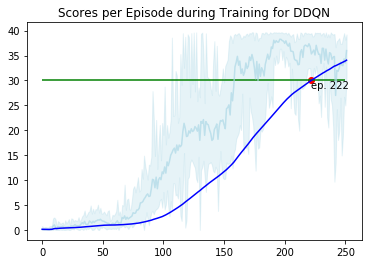

In [8]:
from collections import deque
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

scores = pickle.load( open( "scores.p", "rb" ) )

scores_avg = []
scores_window = deque(maxlen=100)
success = False
for i,x in enumerate(scores):
    
    scores_window.append(np.mean(x))
    m = np.mean(scores_window)
    if m>30 and success == False:
        x_success = i
        y_success = m
        success = True
    scores_avg.append(np.mean(scores_window))
plt.plot([np.mean(x) for x in scores],color='lightblue',alpha=0.7)
mins = [np.min(x) for x in scores]
maxs = [np.max(x) for x in scores]

plt.fill_between(list(range(len(mins))),mins,maxs,color='lightblue',alpha=0.3)

plt.plot(scores_avg, color='blue')
plt.scatter(x_success,y_success, color='red')
plt.text(x_success,y_success-1.5,"ep. {}".format(x_success))
plt.hlines(30.0,0,250, color='green')
plt.title("Scores per Episode during Training for "+ "DDQN")
plt.savefig('learning_ddqn.png')

# Run experiment with final agent

In [ ]:
#import torch
#from ddpg_agent import Agent
#agent = Agent(state_size=33, action_size=4, random_seed=0)

#agent.actor_target.load_state_dict(torch.load('checkpoint_actor.pth'))
#agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
#agent.critic_target.load_state_dict(torch.load('checkpoint_critic.pth'))
#agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

Episode 0	Average Score: 37.05749917170033 22.479999497532845 39.60999911464751
Episode 1	Average Score: 37.63899915870279 30.839999310672283 39.61999911442399
Episode 2	Average Score: 37.797999155148865 27.80999937839806 39.61999911442399
Episode 3	Average Score: 37.620999159105125 30.159999325871468 39.639999113976955
Episode 4	Average Score: 38.25199914500117 34.19999923557043 39.58999911509454
Episode 5	Average Score: 37.32999916560948 25.269999435171485 39.6699991133064
Episode 6	Average Score: 36.99649917306378 22.03999950736761 39.62999911420047
Episode 7	Average Score: 38.8099991325289 35.649999203160405 39.639999113976955
Episode 8	Average Score: 38.00499915052205 31.229999301955104 39.65999911352992
Episode 9	Average Score: 37.43349916329608 32.6099992711097 39.62999911420047
Episode 10	Average Score: 37.766999155841766 29.809999333694577 39.64999911375344
Episode 11	Average Score: 36.82999917678535 22.519999496638775 39.61999911442399
Episode 12	Average Score: 37.83049915442

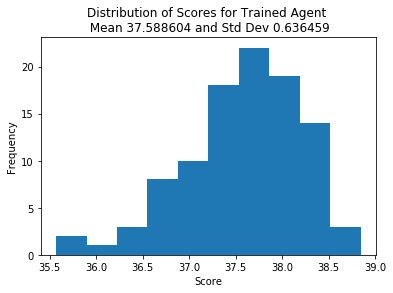

In [12]:
from collections import deque

scorelist = []
score = []
number_of_agents = 20

for i_episode in range(100):
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment  
    states = env_info.vector_observations                 # get the current state
    agent.reset()
    scores = np.zeros(number_of_agents)
    for t in range(2000):
        actions = None
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        next_states = env_info.vector_observations       # get the next state
        rewards = env_info.rewards                        # get the reward
        dones = env_info.local_done                       # see if episode has finished
        states = next_states
        scores += env_info.rewards
        if np.any(dones):
            break
    scorelist.append(scores)

    score_mean = np.mean(scores)
    score_min = np.min(scores)
    score_max = np.max(scores)
    score.append(score_mean)

    print('\rEpisode {}\tAverage Score: {} {} {}'.format(i_episode, score_mean, score_min, score_max))

pickle.dump(scorelist, open( "scores_eval.p", "wb" ))

plt.xlabel('Score')
plt.ylabel('Frequency')
mean = np.mean([np.mean(score) for score in scorelist])
std = np.std([np.mean(score) for score in scorelist])
plt.title('Distribution of Scores for Trained Agent \n Mean {:2f} and Std Dev {:2f}'.format(mean, std))
plt.hist([np.mean(score) for score in scorelist])
plt.savefig('reacher_20_arms_solved.png')